# Setup the directories

In [1]:
import os
base_dir = '/home/ayan/Documents/Computer Vision/Classification/Cat_Vs_Dog/cats_and_dogs_images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Data Preprocessing using ImageDataGenerator
ImageDataGenerator converts image files into batches of preprocessed tensors
Note: A Python generator is an object that acts as an iterator

In [2]:
from keras.preprocessing.image import ImageDataGenerator

#Rescale all pixel values between 0 - 255 to (1, 0)
train_idg = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True, )
test_idg = ImageDataGenerator(rescale = 1./255) #Validation images are not augmented

train_gen = train_idg.flow_from_directory(
    train_dir,
    target_size = (150, 150),       #resize images to (150, 150)
    batch_size = 32,                #32samples per batch i.e. shape = (32, 150, 150, 3)
    class_mode = 'binary'           #since this is a binary classification problem
)

valid_gen = test_idg.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Build a small ConvNet model
This is the most time consuming section.
I noticed that I am getting a better training accuracy using filter size = 5 and strides = 2 compared to MaxPooling

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)       

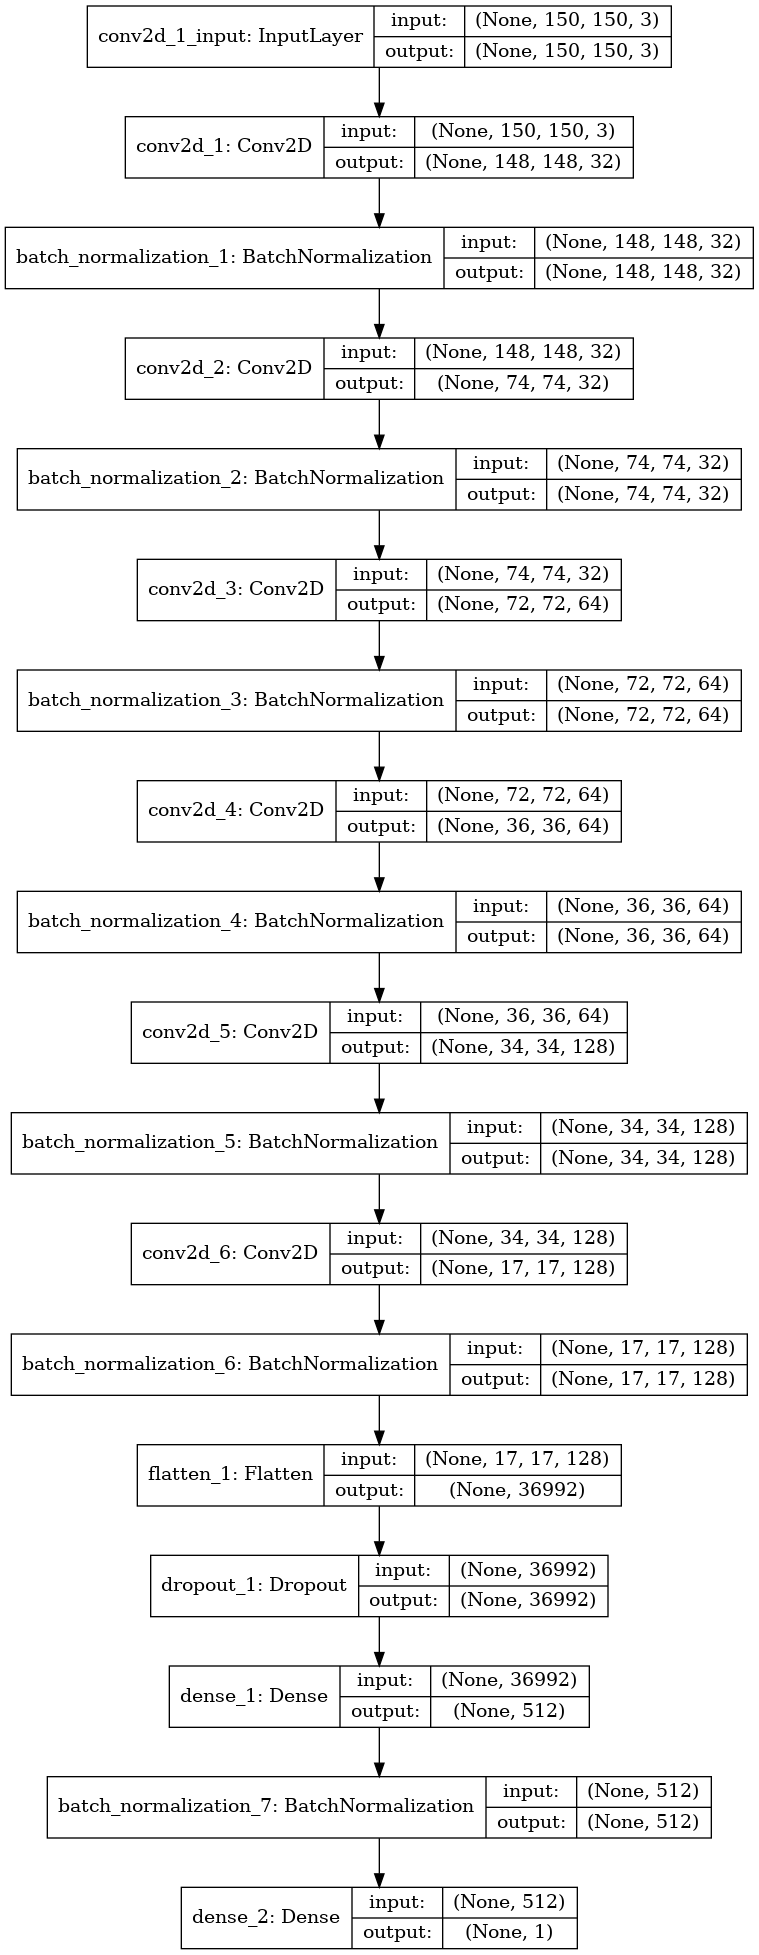

In [3]:
from keras.layers import Conv2D, BatchNormalization, Flatten, Dropout, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu',
                input_shape = (150, 150, 3))) #channel last; num of params = (32 * ((3 * 3 * 3) + 1)) = 896
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

from keras.utils import plot_model
plot_model(model, show_shapes = True, to_file = 'data-aug_convnet.png')

# Setup & configure optimizers

In [4]:
from keras import optimizers
from keras import losses
from keras import metrics

model.compile(optimizer = optimizers.Adam(lr = 1e-4),
             loss = losses.binary_crossentropy,
             metrics = [metrics.binary_accuracy])

# Use batch generator
'steps_per_epoch' is for telling the fit_generator that it needs to run mentioned number of gradient descent steps before drawing the next epoch batch
'validation_steps' tells the process about number of batches to draw from the validation generator

In [5]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = 170,
    epochs = 90,
    validation_data = valid_gen,
    validation_steps = 50)

Epoch 1/90
170/170 [==============================] - 22s 132ms/step - loss: 0.9803 - binary_accuracy: 0.5940 - val_loss: 1.3670 - val_binary_accuracy: 0.5019
Epoch 2/90
170/170 [==============================] - 20s 119ms/step - loss: 0.6730 - binary_accuracy: 0.6562 - val_loss: 0.9056 - val_binary_accuracy: 0.5097
Epoch 3/90
170/170 [==============================] - 20s 118ms/step - loss: 0.6121 - binary_accuracy: 0.6877 - val_loss: 0.8208 - val_binary_accuracy: 0.5945
Epoch 4/90
170/170 [==============================] - 20s 117ms/step - loss: 0.5900 - binary_accuracy: 0.6942 - val_loss: 0.4930 - val_binary_accuracy: 0.6952
Epoch 5/90
170/170 [==============================] - 21s 121ms/step - loss: 0.5599 - binary_accuracy: 0.7269 - val_loss: 0.7021 - val_binary_accuracy: 0.7367
Epoch 6/90
170/170 [==============================] - 21s 121ms/step - loss: 0.5471 - binary_accuracy: 0.7238 - val_loss: 0.4974 - val_binary_accuracy: 0.7159
Epoch 7/90
170/170 [==========================

170/170 [==============================] - 20s 120ms/step - loss: 0.2106 - binary_accuracy: 0.9181 - val_loss: 0.5722 - val_binary_accuracy: 0.8061
Epoch 53/90
170/170 [==============================] - 20s 117ms/step - loss: 0.1923 - binary_accuracy: 0.9199 - val_loss: 0.3895 - val_binary_accuracy: 0.7982
Epoch 54/90
170/170 [==============================] - 20s 115ms/step - loss: 0.1907 - binary_accuracy: 0.9210 - val_loss: 0.5850 - val_binary_accuracy: 0.7932
Epoch 55/90
170/170 [==============================] - 21s 122ms/step - loss: 0.1936 - binary_accuracy: 0.9201 - val_loss: 0.6772 - val_binary_accuracy: 0.8179
Epoch 56/90
170/170 [==============================] - 20s 120ms/step - loss: 0.1839 - binary_accuracy: 0.9241 - val_loss: 0.4290 - val_binary_accuracy: 0.8138
Epoch 57/90
170/170 [==============================] - 20s 119ms/step - loss: 0.1901 - binary_accuracy: 0.9216 - val_loss: 0.6208 - val_binary_accuracy: 0.8151
Epoch 58/90
170/170 [==============================]

# Display training vs validation 

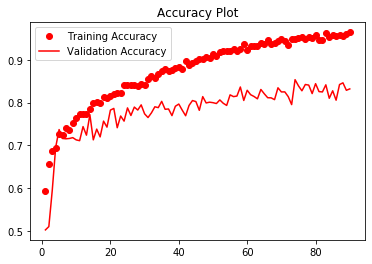

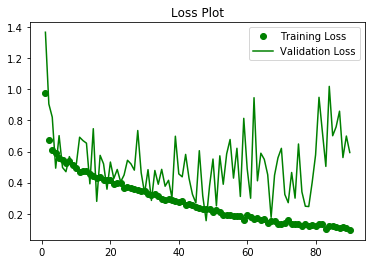

In [6]:
import matplotlib.pyplot as plt
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'ro', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()